In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
# get the data (doesnt matter what, we are just demonstrating fourier transforms
# will use training data -> largest sample size
df = pd.read_csv("exoData/exoTrain.csv")
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [3]:
# change the labels around, make 1 = exoplanet, 0 = no exoplanet.

df["LABEL"] = df["LABEL"].map({2:1, 1:0})
print(df["LABEL"].unique())

[1 0]


## Fourier Transforms Recap

Much like a Taylor series, which is $\forall f(x)$,
$$
f(x) = \sum_{n=1}^\infty{\frac{(x-a)^n}{n!}\frac{\partial^n f}{\partial x^2}(a)}
$$
A Fourier series is the same idea. Instead of any $f(x)$ being a sum of infinitely many polynomials, it can also be expressed as a sum of infinitely many sine (equivalently, cosine) waves.
$$
f(x) = \frac12 a_0 + \sum_{n=1}^\infty {a_n \cos{nx} + b_n \sin{nx}}
$$

Where

$$
a_m = \frac1\pi \int_{-\pi}^\pi {f(x)\cos{nx}\text{ }dx}
$$

$$
b_m = \frac1\pi \int_{-\pi}^\pi {f(x)\sin{nx}\text{ }dx}
$$

Though, the complex forms of the FTs are both more useful and easier to remember. They are also how the [SciPy 1d Fourier analysis packages](https://docs.scipy.org/doc/scipy/tutorial/fft.html) are coded

The Fourier transform is derived from this idea, and enables us to 'deconstruct' a signal into its components. This is especially usefil when looking at the lightcurves we have.

What we get out of the transforms are the frequencies that present in the light curve, and the amplitudes at which they do. So, a highly persistant, low-frequency orbital period of an exoplanet would show as a tall spike early in the frequency-domain data.

In [4]:
# Plot a lightcurve again, but globally define dictionaries first
# Label dictionary
label_dict = {
    1: "Exoplanet",
    0: "No Exoplanet"
}

# Colour dictionary
c_label = {
    1: "blue",
    0: "red"
}

def plot_lc_idx(df, idx): # Takes the data and the star we want to plot
    flux = df.iloc[idx]
    
    label = flux["LABEL"] # isolate labels
    flux = flux.drop(["LABEL"]) # get flux array

    # arbitrary timesteps
    time = np.arange(len(flux))
    
    plt.figure(figsize=(8,6))
    plt.plot(time, flux, linewidth=1, c=c_label[label])
    plt.title(f"LC of star {idx + 1}, Class: {label_dict[label]}")
    plt.ylabel("Flux [Apparent Magnitude]")
    plt.xlabel("Time steps")
    plt.tight_layout()
    plt.show()

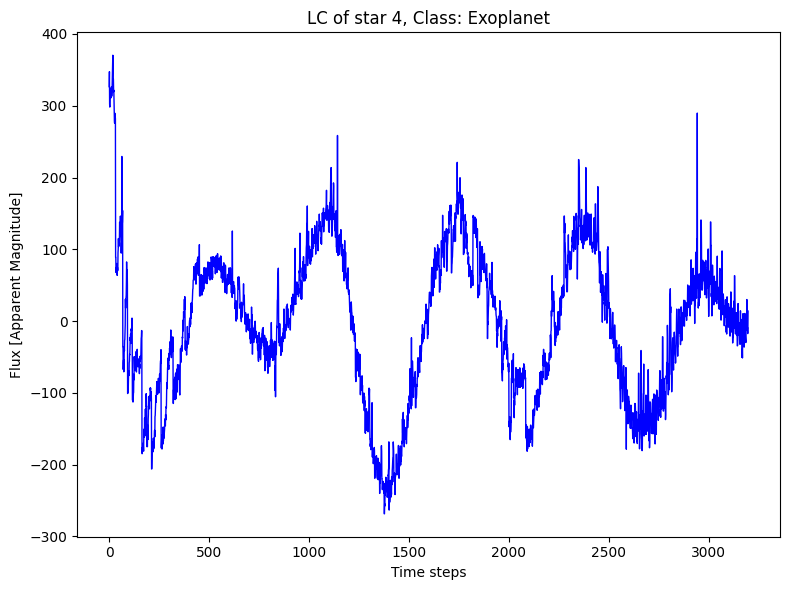

In [5]:
plot_lc_idx(df, 3)

In [6]:
from scipy.fft import rfftfreq, rfft

def plot_fft_lc(df, idx):

    # as before ->
    flux = df.iloc[idx]
    label = flux["LABEL"] # isolate labels
    flux = flux.drop(["LABEL"]) # get flux array
    N = len(flux)
    time = np.arange(N) # timesteps

    # preparing for fft
    flux -= np.mean(flux) # <- detrend flux data to FT

    # fft
    freqs = rfftfreq(len(flux), d=np.median(np.diff(time)))
    amps = np.abs(rfft(flux))
    
    # subplots
    f, a = plt.subplots(1, 2, figsize=(16,6))
    a[0].plot(time, flux, linewidth=1, c=c_label[label])
    a[0].set_title(f"LC of star {idx + 1}, Class: {label_dict[label]}")
    a[0].set_ylabel("Flux [Apparent Magnitude]")
    a[0].set_xlabel("Time steps")

    a[1].plot(freqs, amps, c="g")
    a[1].set_title("FFT of Light Curve")
    a[1].set_xlabel("Frequency [1/time unit]")
    a[1].set_ylabel("Amplitude")
    
    plt.tight_layout()
    plt.show()

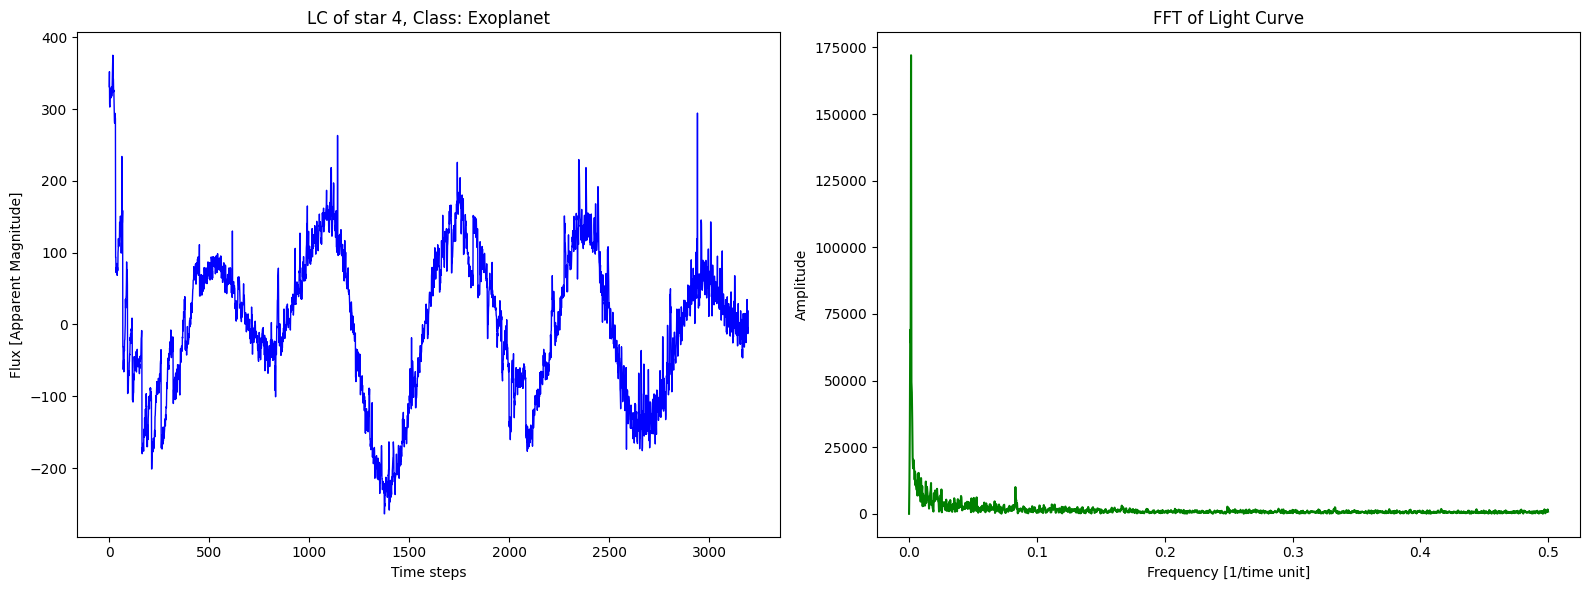

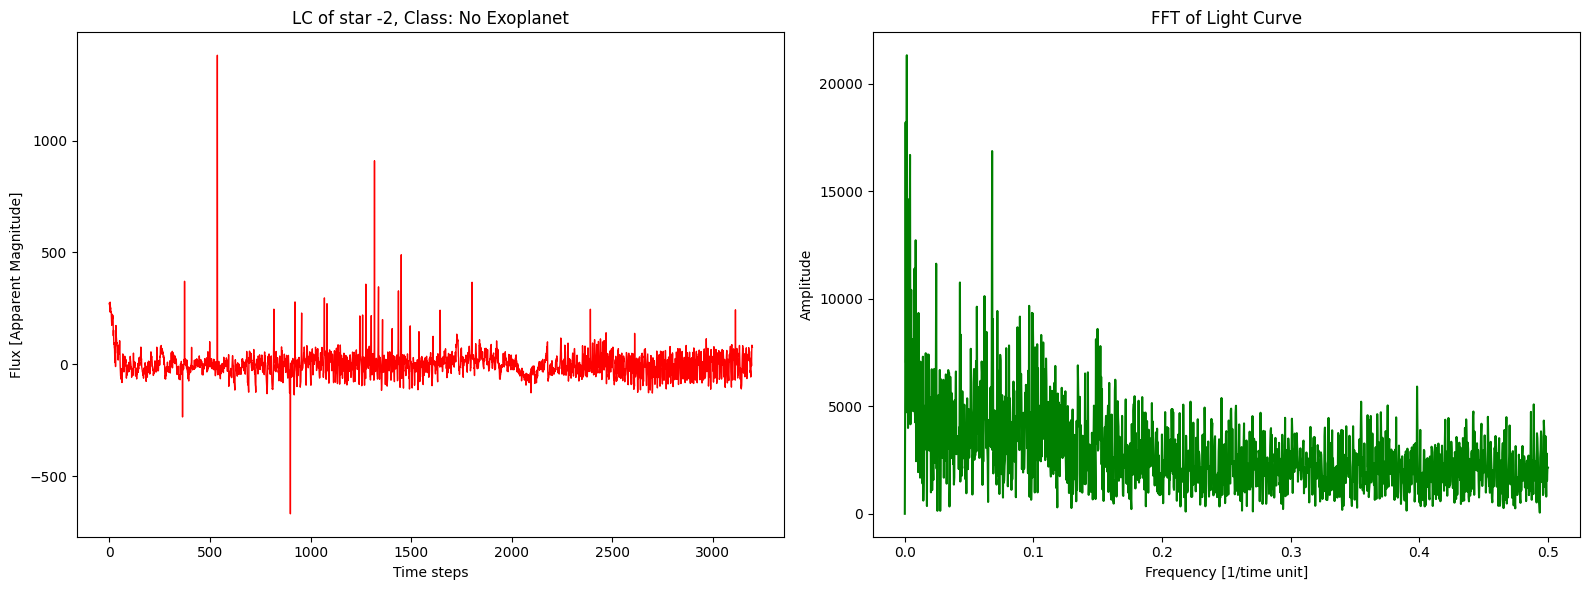

In [7]:
plot_fft_lc(df, 3) # known exoplanet

plot_fft_lc(df, -3) # known non-exoplanet

In [8]:
# We do expect this kind of behavour from the FT graphs of each. 
# An ideal exoplanet would eclipse its stellar host at a regular, observable frequency
# => our favourite star 4 (df.iloc[3] flux readings) shows a light curve that even humans can classify.

# this is cause for some preprocessing.
# 1. de-trend every row
# 2. normalise every row,
# => give each light curve mu=0, sigma=1.

df = pd.read_csv("exoData/exoTrain.csv")
df["LABEL"] = df["LABEL"].map({2:1, 1:0}) # remap labels

# split into X, y first
X = df.drop(["LABEL"], axis=1)
y = df["LABEL"]

# since sklearn's StandardScaler works by column, we do this manually.
means = X.mean(axis=1)
stdvs = X.std(axis=1)

X = X.sub(means, axis=0).div(stdvs, axis=0)

In [9]:
print(X.shape, y.shape)

(5087, 3197) (5087,)


In [10]:
# ensure that each row meets our criteria
import random

for _ in range(5):
    j = random.randint(0, X.shape[0]-1)
    print(
        f"Testing row {j}\n Mean:", X.iloc[j].mean(), "\n Standard Deviation:", X.iloc[j].std(), "\n"
    )

Testing row 2753
 Mean: 8.890118683266815e-17 
 Standard Deviation: 1.0 

Testing row 2100
 Mean: -1.778023736653363e-17 
 Standard Deviation: 0.9999999999999998 

Testing row 265
 Mean: -7.112094946613452e-17 
 Standard Deviation: 1.0 

Testing row 3564
 Mean: -1.0668142419920179e-16 
 Standard Deviation: 1.0 

Testing row 2368
 Mean: -1.3335178024900223e-17 
 Standard Deviation: 0.9999999999999999 



In [ ]:
# These mean values are floating point noise, this is perfectly fine. The scaling worked.
# Now, we want to fft the data.

def FT(X):
    return np.abs(rfft(X, axis=1))

## Savitzky Golay filter

A type of smoothing filter that fits a low-order polynomial over sequential windows of signal.

In [12]:
from scipy.signal import savgol_filter

def savgol_FT(df, idx): # takes the df, and a star we want to plot everything of.
    # all the following as before ->
    flux = df.iloc[idx]
    label = flux["LABEL"] # isolate labels
    flux = flux.drop(["LABEL"]) # get flux array
    N = len(flux)

    # have the four arrays necessary
    time = np.arange(N) # timesteps
    freqs = rfftfreq(len(flux), d=np.median(np.diff(time)))
    amps = np.abs(rfft(flux))

    # savgol
    amps_smooth = savgol_filter(amps, window_length=11, polyorder=3)
    
    # subplots
    f, a = plt.subplots(1, 2, figsize=(16,6))
    a[0].plot(time, flux, linewidth=1, c=c_label[label])
    a[0].set_title(f"LC of star {idx + 1}, Class: {label_dict[label]}")
    a[0].set_ylabel("Flux [Apparent Magnitude]")
    a[0].set_xlabel("Time steps")

    a[1].plot(freqs, amps, c="g")
    a[1].plot(freqs, amps_smooth, c="orange")
    a[1].set_title("FFT of Light Curve w/ Savgol")
    a[1].set_xlabel("Frequency [1/time unit]")
    a[1].set_ylabel("Amplitude")
    
    plt.tight_layout()
    plt.show()

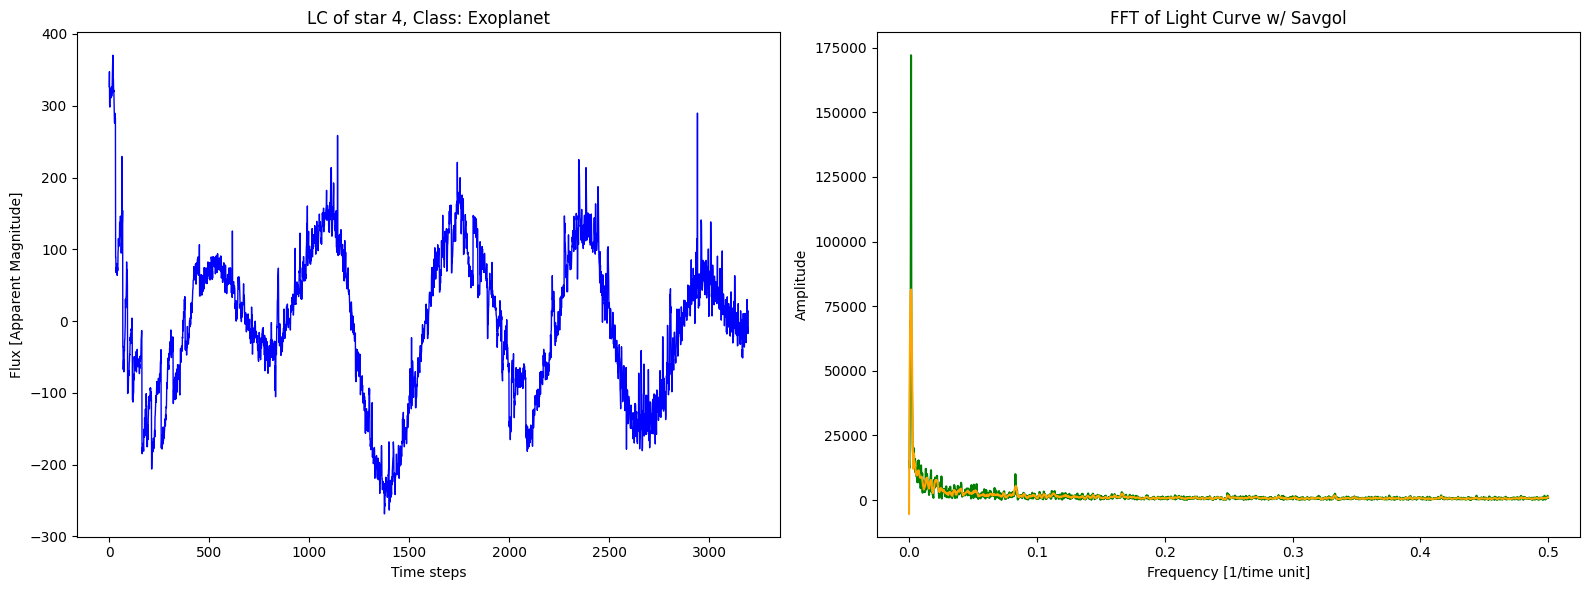

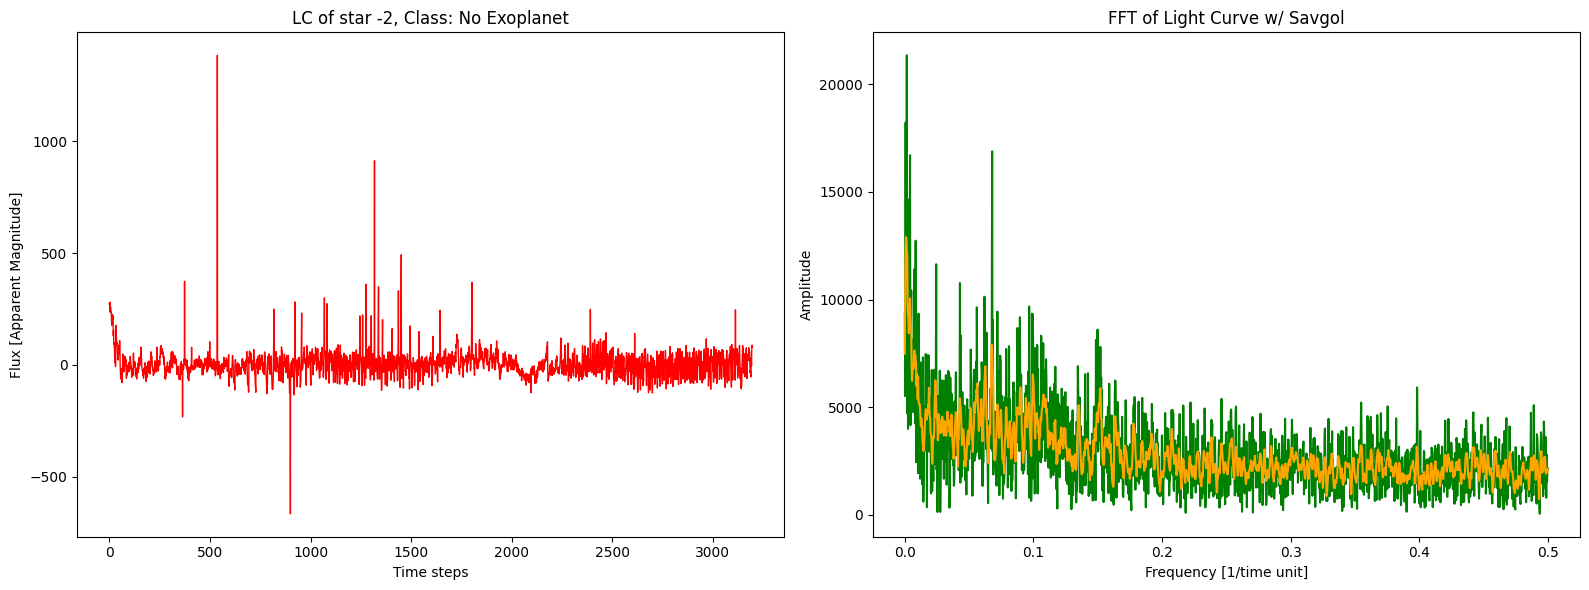

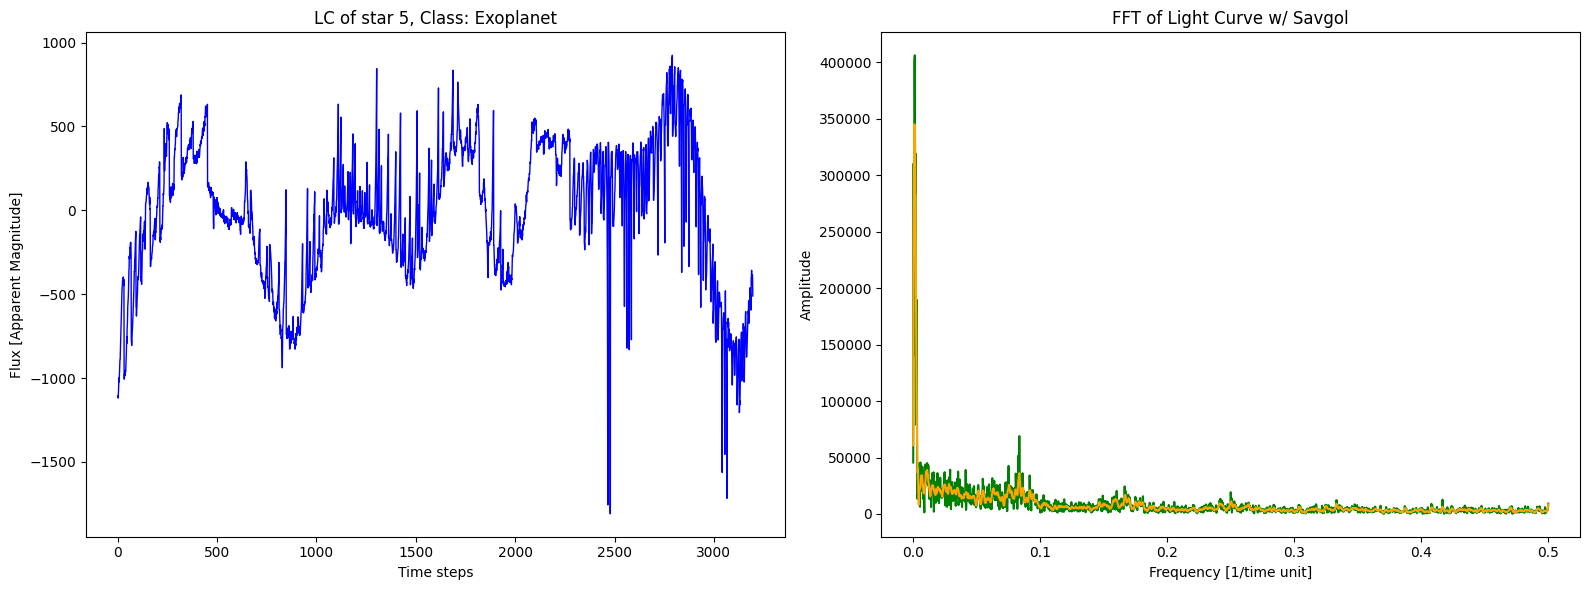

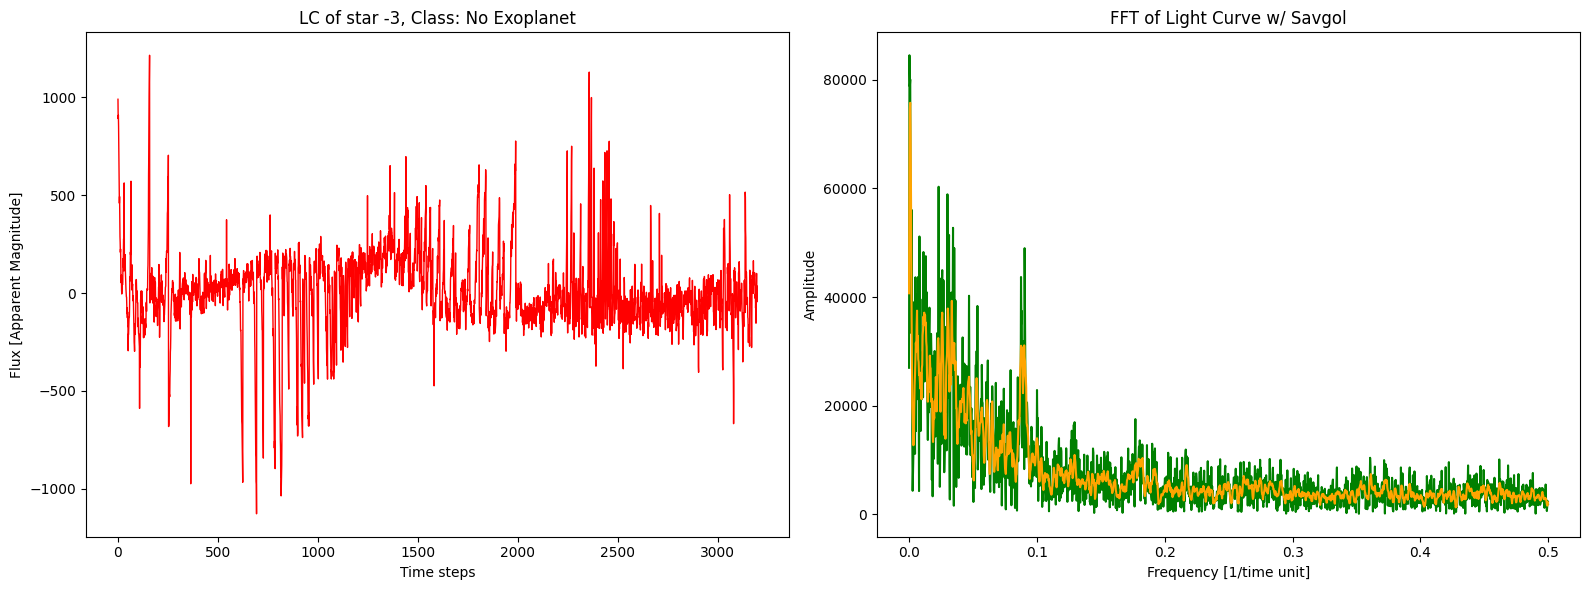

In [13]:
savgol_FT(df, 3)
savgol_FT(df, -3)

savgol_FT(df, 4)
savgol_FT(df, -4)

The final issue we now face is the potential low-frequency information potentially being diluted by the CNN. Given that we know the main difference between the curves is within the first part of frequency data, lets log1p.

In [14]:
# lets write a preprocessing pipeline, so that we can take the raw data and extract a filtered FT light curve:

# start from the beginning, and split the classes from the features
df = pd.read_csv("exoData/exoTrain.csv")
df["LABEL"] = df["LABEL"].map({2:1, 1:0})

X = df.drop(["LABEL"], axis=1)
y = df["LABEL"]

def preprocess(X): # light curves (rows) - no label column

    # 1. zero-mean, unit-variance scaling across the time-domain
    X = X.sub(X.mean(axis=1), axis=0).div(X.std(axis=1), axis=0).fillna(0)

    # 2. Fourier transform the lightcurves
    X = np.abs(rfft(X, axis=1))

    # 3. Savitzky Golay smoothing
    X = savgol_filter(X, window_length=13, polyorder=3, axis=1)

    # 4. Emphasise early frequency features using log1p
    X = np.clip(X, 0, None)
    return np.log1p(X) # <- ML-ready log(frequency) -domain data

X = preprocess(X)

In [ ]:
import torch
import torch.nn as nn
import pandas as pd

# define a 1d cnn

class ExoCNN(nn.Module):
    def __init__(self, input_length):
        super(ExoCNN, self).__init__()

        # 1d convolutional layers
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)

        # max pooling
        self.pool = nn.MaxPool1d(kernel_size=2)

        fc_input = (input_length // 8) * 64  # 3 layers of pool size 2 -> divide by 2^3 = 8
        self.fc1 = nn.Linear(fc_input, 128)
        self.fc2 = nn.Linear(128, 1) # binary classification

        # ReU activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # x.shape: [batch_size, 1, input_length]
        
        # 1d conv layer 1
        x = self.conv1(x) # [batch_size, 16, input_length]
        x = self.relu(x)
        x = self.pool(x) # input_length -> input_length//2

        # 1d conv layer 2
        x = self.conv2(x) # [batch_size, 32, input_length//2]
        x = self.relu(x)
        x = self.pool(x) # input_length//2 -> input_length//4

        # 1d conv layer 3
        x = self.conv3(x) # [batch_size, 64, input_length//4]
        x = self.relu(x)
        x = self.pool(x) # input_length//4 -> input_length//8

        # flatten for linear transformations:
        # reshapes from [batch_size, 64, input_length//8]
        x = x.view(x.size(0), -1) # -> [batch_size, 64 * input_length//8]

        # 2 affine linear transformations
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x # <- pure logits, we handle class imbalance later

In [17]:
# load, preprocess and relabel all in one function
from torch.utils.data import Dataset, DataLoader

def prepare_data(filepath):
    data = pd.read_csv(filepath)

    # split X, y
    X = data.drop(["LABEL"], axis=1)
    y = data["LABEL"].map({2:1,1:0}) # relabel

    # preprocess X with existing pipeline
    X = preprocess(X)

    return X, y

class LC_dataset(Dataset):
    def __init__(self, X, y):
        # ensure all values are numerical
        self.X = X.astype("float32")
        self.y = y.astype("float32")

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).unsqueeze(0)
        label = torch.tensor([self.y[idx]], dtype=torch.float32)
        return x, label

In [18]:
# load training and testing data
train_ds = LC_dataset(*prepare_data("exoData/exoTrain.csv"))
test_ds = LC_dataset(*prepare_data("exoData/exoTest.csv"))

batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get input length
L = train_ds[0][0].shape[-1]
print("input_length L =", L)

input_length L = 1599


In [19]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

n = 8 # no. epochs
cnn = ExoCNN(L).to(device)

pos_weight = torch.tensor([100.0], device=device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimiser = optim.Adam(cnn.parameters(), lr=0.001)

for epoch in range(n):

    running_loss = 0.0
    cnn.train() # initialise training

    for batch_idx, (inputs, labels) in enumerate(train_dl):

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimiser.zero_grad()
        outputs = cnn(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimiser.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_dl)
    print(f"Epoch [{epoch+1}/{n}] - Loss: {avg_loss:.4f}")

Device: cpu
Epoch [1/8] - Loss: 1.3240
Epoch [2/8] - Loss: 1.1516
Epoch [3/8] - Loss: 1.1316
Epoch [4/8] - Loss: 1.2009
Epoch [5/8] - Loss: 1.1994
Epoch [6/8] - Loss: 1.1830
Epoch [7/8] - Loss: 1.2393
Epoch [8/8] - Loss: 1.1577


In [20]:
# evaluate the model
import numpy as np

cnn.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = cnn(inputs)

        # need to make a decision
        preds = (outputs >= 0.5).int()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# flatten into single arrays
all_preds = np.vstack(all_preds).flatten()
all_labels = np.vstack(all_labels).flatten()

In [21]:
# see what the model did with a CM
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
print(cm)

[[565   0]
 [  5   0]]
